# Logistic regression for text analysis with L2 regularization

In [1]:
from __future__ import division
import turicreate

In [2]:
products = turicreate.SFrame('amazon_baby_subset.sframe/')

In [3]:

import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

import string 
def remove_punctuation(text):
    translator = text.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [4]:
train_data, validation_data = products.random_split(.8, seed=2)

In [5]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [6]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

In [8]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix,coefficients)
    
    predictions = 1/(1 + np.exp(-score))

    return predictions

In [11]:
def feature_derivative(errors, feature, coefficient, l2_penalty, feature_is_constant):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors,feature) 
    
    if not feature_is_constant:
        derivative = np.dot(errors,feature)- 2*l2_penalty*coefficient

    # Return the derivative
    return derivative

In [12]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [13]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) 
    for itr in range(max_iter):
        
        predictions = predict_probability(feature_matrix,coefficients)
        
        indicator = (sentiment == +1)
        
        errors = indicator - predictions
        
        for j in range(len(coefficients)): 
            
            is_intercept = (j == 0)
            
            derivative = feature_derivative(errors,feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            coefficients[j] += step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

In [14]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39138303
iteration   1: log likelihood of observed labels = -29003.71259047
iteration   2: log likelihood of observed labels = -28834.66187288
iteration   3: log likelihood of observed labels = -28671.70781507
iteration   4: log likelihood of observed labels = -28514.43078198
iteration   5: log likelihood of observed labels = -28362.48344665
iteration   6: log likelihood of observed labels = -28215.56713122
iteration   7: log likelihood of observed labels = -28073.41743783
iteration   8: log likelihood of observed labels = -27935.79536396
iteration   9: log likelihood of observed labels = -27802.48168669
iteration  10: log likelihood of observed labels = -27673.27331484
iteration  11: log likelihood of observed labels = -27547.98083656
iteration  12: log likelihood of observed labels = -27426.42679977
iteration  13: log likelihood of observed labels = -27308.44444728
iteration  14: log likelihood of observed labels = -27193.8767

In [15]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.39508175
iteration   1: log likelihood of observed labels = -29003.73417180
iteration   2: log likelihood of observed labels = -28834.71441858
iteration   3: log likelihood of observed labels = -28671.80345068
iteration   4: log likelihood of observed labels = -28514.58077957
iteration   5: log likelihood of observed labels = -28362.69830317
iteration   6: log likelihood of observed labels = -28215.85663259
iteration   7: log likelihood of observed labels = -28073.79071393
iteration   8: log likelihood of observed labels = -27936.26093762
iteration   9: log likelihood of observed labels = -27803.04751805
iteration  10: log likelihood of observed labels = -27673.94684207
iteration  11: log likelihood of observed labels = -27548.76901327
iteration  12: log likelihood of observed labels = -27427.33612958
iteration  13: log likelihood of observed labels = -27309.48101569
iteration  14: log likelihood of observed labels = -27195.0462

In [16]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.40062984
iteration   1: log likelihood of observed labels = -29003.76654163
iteration   2: log likelihood of observed labels = -28834.79322654
iteration   3: log likelihood of observed labels = -28671.94687528
iteration   4: log likelihood of observed labels = -28514.80571589
iteration   5: log likelihood of observed labels = -28363.02048079
iteration   6: log likelihood of observed labels = -28216.29071186
iteration   7: log likelihood of observed labels = -28074.35036891
iteration   8: log likelihood of observed labels = -27936.95892966
iteration   9: log likelihood of observed labels = -27803.89576265
iteration  10: log likelihood of observed labels = -27674.95647005
iteration  11: log likelihood of observed labels = -27549.95042714
iteration  12: log likelihood of observed labels = -27428.69905549
iteration  13: log likelihood of observed labels = -27311.03455140
iteration  14: log likelihood of observed labels = -27196.7989

In [17]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.48385120
iteration   1: log likelihood of observed labels = -29004.25177457
iteration   2: log likelihood of observed labels = -28835.97382190
iteration   3: log likelihood of observed labels = -28674.09410083
iteration   4: log likelihood of observed labels = -28518.17112932
iteration   5: log likelihood of observed labels = -28367.83774654
iteration   6: log likelihood of observed labels = -28222.77708939
iteration   7: log likelihood of observed labels = -28082.70799392
iteration   8: log likelihood of observed labels = -27947.37595368
iteration   9: log likelihood of observed labels = -27816.54738615
iteration  10: log likelihood of observed labels = -27690.00588850
iteration  11: log likelihood of observed labels = -27567.54970126
iteration  12: log likelihood of observed labels = -27448.98991327
iteration  13: log likelihood of observed labels = -27334.14912742
iteration  14: log likelihood of observed labels = -27222.8604

In [18]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.31606471
iteration   1: log likelihood of observed labels = -29009.07176112
iteration   2: log likelihood of observed labels = -28847.62378912
iteration   3: log likelihood of observed labels = -28695.14439397
iteration   4: log likelihood of observed labels = -28550.95060743
iteration   5: log likelihood of observed labels = -28414.45771129
iteration   6: log likelihood of observed labels = -28285.15124375
iteration   7: log likelihood of observed labels = -28162.56976044
iteration   8: log likelihood of observed labels = -28046.29387744
iteration   9: log likelihood of observed labels = -27935.93902900
iteration  10: log likelihood of observed labels = -27831.15045502
iteration  11: log likelihood of observed labels = -27731.59955260
iteration  12: log likelihood of observed labels = -27636.98108219
iteration  13: log likelihood of observed labels = -27547.01092670
iteration  14: log likelihood of observed labels = -27461.4242

In [19]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.85955115
iteration   1: log likelihood of observed labels = -29271.71006589
iteration   2: log likelihood of observed labels = -29271.65738833
iteration   3: log likelihood of observed labels = -29271.61189923
iteration   4: log likelihood of observed labels = -29271.57079975
iteration   5: log likelihood of observed labels = -29271.53358505
iteration   6: log likelihood of observed labels = -29271.49988440
iteration   7: log likelihood of observed labels = -29271.46936584
iteration   8: log likelihood of observed labels = -29271.44172890
iteration   9: log likelihood of observed labels = -29271.41670149
iteration  10: log likelihood of observed labels = -29271.39403722
iteration  11: log likelihood of observed labels = -29271.37351294
iteration  12: log likelihood of observed labels = -29271.35492661
iteration  13: log likelihood of observed labels = -29271.33809523
iteration  14: log likelihood of observed labels = -29271.3228

In [20]:
table = turicreate.SFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [21]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
(intercept),-0.06374213522751732,-0.0631430877073719,-0.06225594377004494,-0.050438365195277945
baby,0.07407300592164348,0.07399385414054367,0.07387735348036836,0.0723603602218292
one,0.012752505778363695,0.012494970448124454,0.01211525295335661,0.007247283318698761
great,0.8016249897781761,0.7968969330033087,0.7899351472214043,0.7014250736748336
love,1.0585539820695435,1.050855680993631,1.0395285158465861,0.8966441331010777
use,-0.00010415219124813696,0.00016285765617722204,0.0005557109757555909,0.0054810326794610155
would,-0.2870214435342971,-0.2860272029746515,-0.2845640355618724,-0.265992746225552
like,-0.00338447399293333,-0.003442085770451775,-0.003527294449660821,-0.004634992832527626
easy,0.9845588198731923,0.9776001497817036,0.9673618366314701,0.8382448329554504
little,0.5244194563643343,0.5213847261068161,0.5169173924914707,0.4602345779024191


In [26]:
positive_table_l20 = table.sort('coefficients [L2=0]', ascending = False)
positive_table_l20

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
love,1.0585539820695435,1.050855680993631,1.0395285158465861,0.8966441331010777
loves,1.0524840477983537,1.043902912902074,1.0312653468918702,0.8707939748225283
easy,0.9845588198731923,0.9776001497817036,0.9673618366314701,0.8382448329554504
perfect,0.8356932076383463,0.8285546747911551,0.8180378375428206,0.6841429449844793
great,0.8016249897781761,0.7968969330033087,0.7899351472214043,0.7014250736748336
happy,0.5573952023634463,0.5524838881179482,0.5452454450870924,0.45280003581636574
best,0.5350338897717771,0.5302646601563841,0.5232359962403251,0.43352640353953825
little,0.5244194563643343,0.5213847261068161,0.5169173924914707,0.4602345779024191
fits,0.4876522532652972,0.48342877019472735,0.4772045913199556,0.39776549601827393
well,0.4538664867675505,0.4509687208177296,0.44670047396569246,0.39230412155576333


In [27]:
positive_words = positive_table_l20['word'][:6]
positive_words

dtype: str
Rows: 6
['love', 'loves', 'easy', 'perfect', 'great', 'happy']

In [28]:
negative_table_l20 = table.sort('coefficients [L2=0]', ascending = True)
negative_table_l20

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
disappointed,-0.9554366281707273,-0.946979918258718,-0.9345184199406323,-0.775625136545788
money,-0.7687931346121052,-0.7627339763998731,-0.753818293983956,-0.6414057524811045
return,-0.7420849546350395,-0.7355024007212443,-0.7258065666864303,-0.6026463562873889
waste,-0.6178091779812257,-0.612474509202332,-0.6046202518853265,-0.5051887579435835
returned,-0.5727070451581127,-0.5675184854879843,-0.5598698491588029,-0.4620556794344292
broke,-0.5551950643136404,-0.5502092466682857,-0.5428605834964957,-0.4489888839184337
work,-0.52671629033099,-0.5229118403261269,-0.5173119104685526,-0.44644742962850564
thought,-0.47785646313838,-0.47395119600332236,-0.4681998280798263,-0.3951721576218487
idea,-0.46536986216939813,-0.4611298832183625,-0.454879213620694,-0.37488995388203544
cheap,-0.45891214821936144,-0.45490892160929286,-0.4490099725703672,-0.3737938215913146


In [29]:
negative_words = negative_table_l20['word'][:6]
negative_words

dtype: str
Rows: 6
['disappointed', 'money', 'return', 'waste', 'returned', 'broke']

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

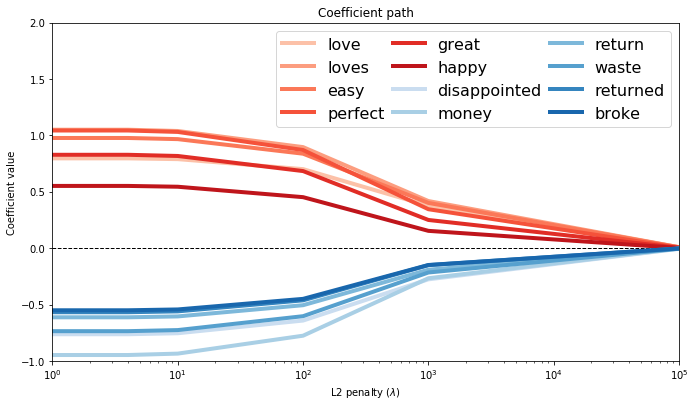

In [31]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

In [32]:
def accuracy(coeff, feature_matrix, sentiment):
    pred = np.dot(feature_matrix, coeff)
    correct = 0
    for i in range(len(sentiment)):
        if pred[i] >= 0.5:
            s = 1
        else:
            s = -1
        if s == sentiment[i]:
            correct += 1
    return correct / len(sentiment)

In [35]:
acc_val = []
coeff = [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty,
                coefficients_1e3_penalty, coefficients_1e5_penalty]
for c in coeff:
    acc_val.append(accuracy(c, feature_matrix_valid, sentiment_valid))
acc_val

[0.754831481654374,
 0.7545513957613669,
 0.7549248436187097,
 0.7459620950424797,
 0.6638035664270376,
 0.5021940061618897]

In [36]:
max(acc_val)

0.7549248436187097

In [37]:
acc_train = []
for c in coeff:
    acc_train.append(accuracy(c, feature_matrix_train, sentiment_train))
acc_train

[0.7574183801137839,
 0.7570878874436392,
 0.7566393616770143,
 0.747692452963811,
 0.6631807558839499,
 0.49843015981681266]

In [38]:
max(acc_train)

0.7574183801137839